In [765]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/test-one-flight/test_one_flight.csv
/kaggle/input/mini-flight-delay-prediction/flight_delays_test.csv
/kaggle/input/mini-flight-delay-prediction/flight_delays_train.csv
/kaggle/input/test-10-flight/test_ten_flights.csv


In [ ]:
#What is the main idea of Gradient Boosting?
#The term “gradient boosting” comes from the idea of “boosting” or improving a single weak model by combining it with a number of other
#weak models in order to generate a collectively strong model. Gradient boosting is an extension of boosting where the process of additively
#generating weak models is formalized as a gradient descent algorithm over an objective function. 

In [746]:
#DATASET FEATURES:

#Month, DayofMonth, DayOfWeek
#DepTime – departure time
#UniqueCarrier – code of a company-career
#Origin – flight origin
#Dest – flight destination
#Distance, distance between Origin and Dest airports
#dep_delayed_15min – target

In [766]:
# modules we'll use
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

import xgboost as xgb

from sklearn.model_selection import train_test_split
# set seed for reproducibility
np.random.seed(0)

In [767]:
traindata = pd.read_csv("../input/mini-flight-delay-prediction/flight_delays_train.csv")

In [768]:
testdata = pd.read_csv("../input/mini-flight-delay-prediction/flight_delays_test.csv")

In [769]:
traindata.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [770]:
testdata.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
0,c-7,c-25,c-3,615,YV,MRY,PHX,598
1,c-4,c-17,c-2,739,WN,LAS,HOU,1235
2,c-12,c-2,c-7,651,MQ,GSP,ORD,577
3,c-3,c-25,c-7,1614,WN,BWI,MHT,377
4,c-6,c-6,c-3,1505,UA,ORD,STL,258


In [771]:
#Find missing values:

missing_values_count = traindata.isnull().sum()
total_cells = np.product(traindata.shape)
total_missing = missing_values_count.sum()
percent_missing = (total_missing/total_cells) * 100
percent_missing

0.0

In [772]:
y = traindata['dep_delayed_15min']
X = traindata.drop(['dep_delayed_15min'], axis = 1)

In [773]:
# Categorical columns in the training data
X_object_cols = [col for col in X.columns if X[col].dtype == "object"]
X_object_cols

['Month', 'DayofMonth', 'DayOfWeek', 'UniqueCarrier', 'Origin', 'Dest']

In [842]:
###NB! We have "object" data here. And must transfer it to numerical by one-hot encoding or dropping. 
#For large datasets with many rows, one-hot encoding can greatly expand the size of the dataset.  
#For this reason, we typically only one-hot encode columns with relatively low cardinality. 
#Then, high cardinality columns can either be dropped from the dataset, or we can use ordinal encoding.
#But ther is the way to pass categorical data into XGBoost.
#https://xgboost.readthedocs.io/en/stable/tutorials/categorical.html

In [774]:
y = traindata['dep_delayed_15min']
y = y.map({ 'Y' : 1, 'N' : 0})

In [775]:
###NB! It must be done for the use of enable_categorical=True in XGBoost
X["Month"] = X["Month"].astype("category")
X["DayofMonth"] = X["DayofMonth"].astype("category")
X["DayOfWeek"] = X["DayOfWeek"].astype("category")
X["UniqueCarrier"] = X["UniqueCarrier"].astype("category")
X["Origin"] = X["Origin"].astype("category")
X["Dest"] = X["Dest"].astype("category")

In [776]:
X.dtypes

Month            category
DayofMonth       category
DayOfWeek        category
DepTime             int64
UniqueCarrier    category
Origin           category
Dest             category
Distance            int64
dtype: object

In [813]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)

In [814]:
testdata["Month"] = testdata["Month"].astype("category")
testdata["DayofMonth"] = testdata["DayofMonth"].astype("category")
testdata["DayOfWeek"] = testdata["DayOfWeek"].astype("category")
testdata["UniqueCarrier"] = testdata["UniqueCarrier"].astype("category")
testdata["Origin"] = testdata["Origin"].astype("category")
testdata["Dest"] = testdata["Dest"].astype("category")

In [815]:
# Supported tree methods are `gpu_hist`, `approx`, and `hist`.
clf = xgb.XGBClassifier(tree_method="hist", enable_categorical=True)
# X is the dataframe we created in previous snippet
clf.fit(X_train, y_train)
# Must use JSON/UBJSON for serialization, otherwise the information is lost.
clf.save_model("categorical-model.json")

In [816]:
clf.feature_importances_

array([0.07889485, 0.10166322, 0.06660858, 0.33157462, 0.08956435,
       0.14191744, 0.14316371, 0.04661326], dtype=float32)

In [817]:
ypred = clf.predict(testdata)

In [818]:
ypred[48]

1

In [819]:
model_acc = clf.score(x_val, y_val)
model_acc

0.81095

In [820]:
scores = -1 * cross_val_score(clf, X, y, cv=5, scoring='accuracy')
scores.mean()

-0.8088599999999999

<AxesSubplot:>

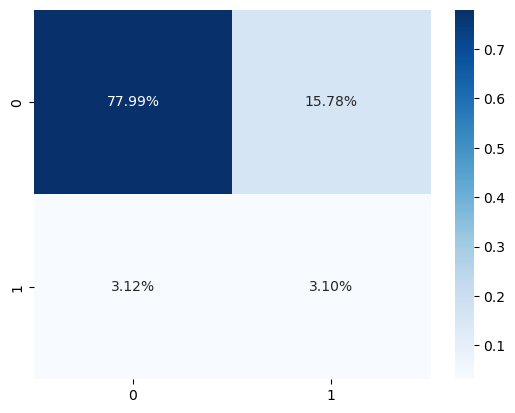

In [821]:
preds = clf.predict(X_val)
cf_matrix = confusion_matrix(preds, y_val)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, cmap='Blues', fmt='.2%')
#Optimize with Gridsearchplt.show()

In [ ]:
# On the Y-axis - Actual condition. On the X-Axis - Predicted condition. 
# Few Positive data with 1 (about 6%) in the dataset.
# The amount of TP = FN = 3%
# Many False Positives (15.78%)

In [822]:
#Optimize with grid search (find the best hyperparameters)
param_grid = {
    'model__n_estimators': [10, 100, 200], 'model__max_leaves': [2, 3, 5, 7, 10]
}

grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy', return_train_score=True)
grid_search.fit(X_train, y_train)

[13:29:40] WARNING: ../src/learner.cc:627: 
Parameters: { "model__max_leaves", "model__n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:29:42] WARNING: ../src/learner.cc:627: 
Parameters: { "model__max_leaves", "model__n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:29:44] WARNING: ../src/learner.cc:627: 
Parameters: { "model__max_leaves", "model__n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  the

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     callbacks=None, colsample_bylevel=1,
                                     colsample_bynode=1, colsample_bytree=1,
                                     early_stopping_rounds=None,
                                     enable_categorical=True, eval_metric=None,
                                     gamma=0, gpu_id=-1,
                                     grow_policy='depthwise',
                                     importance_type=None,
                                     interaction_constraints='',
                                     learning_rate=0.300000012, max_bin=256,
                                     max_cat_to_onehot=4, max_delta_step=0,
                                     max_depth=6, max_leaves=0,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                    

In [823]:
grid_search.best_params_

{'model__max_leaves': 2, 'model__n_estimators': 10}

In [824]:
clf_best_model = grid_search.best_estimator_.fit(X_train, y_train)

[13:33:01] WARNING: ../src/learner.cc:627: 
Parameters: { "model__max_leaves", "model__n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [825]:
clf_best_model.feature_importances_

array([0.07889485, 0.10166322, 0.06660858, 0.33157462, 0.08956435,
       0.14191744, 0.14316371, 0.04661326], dtype=float32)

In [826]:
model_acc = clf_best_model.score(x_val, y_val)
model_acc

0.81095

In [827]:
scores = -1 * cross_val_score(clf_best_model, X, y, cv=5, scoring='accuracy')
scores.mean()

[13:33:28] WARNING: ../src/learner.cc:627: 
Parameters: { "model__max_leaves", "model__n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:33:31] WARNING: ../src/learner.cc:627: 
Parameters: { "model__max_leaves", "model__n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:33:33] WARNING: ../src/learner.cc:627: 
Parameters: { "model__max_leaves", "model__n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  the

-0.8088599999999999

In [835]:
test10flight = pd.read_csv("../input/test-10-flight/test_ten_flights.csv")

In [836]:
test10flight["Month"] = test10flight["Month"].astype("category")
test10flight["DayofMonth"] = test10flight["DayofMonth"].astype("category")
test10flight["DayOfWeek"] = test10flight["DayOfWeek"].astype("category")
test10flight["UniqueCarrier"] = test10flight["UniqueCarrier"].astype("category")
test10flight["Origin"] = test10flight["Origin"].astype("category")
test10flight["Dest"] = test10flight["Dest"].astype("category")

In [837]:
test10flight

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y
1,c-10,c-14,c-5,1704,OO,SLC,SEA,689,Y
2,c-6,c-21,c-3,1519,EV,ATL,ILM,377,Y
3,c-12,c-3,c-7,1653,EV,ATL,MYR,317,Y
4,c-3,c-24,c-4,2303,US,CLT,CHS,168,Y
5,c-5,c-6,c-5,1728,WN,SAN,SMF,480,Y
6,c-10,c-20,c-5,2312,AQ,OAK,LAS,407,Y
7,c-9,c-9,c-6,1520,YV,SEA,PHX,1107,Y
8,c-9,c-5,c-2,1831,FL,ATL,MSP,906,Y
9,c-6,c-6,c-2,1932,UA,DEN,DTW,1123,Y


In [838]:
test10flight.dtypes

Month                category
DayofMonth           category
DayOfWeek            category
DepTime                 int64
UniqueCarrier        category
Origin               category
Dest                 category
Distance                int64
dep_delayed_15min      object
dtype: object

In [839]:
X10test = test10flight.drop(['dep_delayed_15min'], axis = 1)
X10test

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
0,c-10,c-7,c-6,1828,WN,MDW,OMA,423
1,c-10,c-14,c-5,1704,OO,SLC,SEA,689
2,c-6,c-21,c-3,1519,EV,ATL,ILM,377
3,c-12,c-3,c-7,1653,EV,ATL,MYR,317
4,c-3,c-24,c-4,2303,US,CLT,CHS,168
5,c-5,c-6,c-5,1728,WN,SAN,SMF,480
6,c-10,c-20,c-5,2312,AQ,OAK,LAS,407
7,c-9,c-9,c-6,1520,YV,SEA,PHX,1107
8,c-9,c-5,c-2,1831,FL,ATL,MSP,906
9,c-6,c-6,c-2,1932,UA,DEN,DTW,1123


In [840]:
y10pred = clf.predict(X10test)
y10pred

#Many FALSE NEGATIVES

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0])